# 用于算法交易的神经网络——正确的时间序列预测和回测
我想展示如何用不同的方法来归一化数据，并且讨论更多的过拟合相关问题。

In [1]:
import QUANTAXIS as QA
#import tushare as TU
#import rqalpha as RQ
#import funcat as FA
#import tensorflow as TF
#import numpy as np
#import pandas as pd
import time
import datetime
#import pp
#job = job_server.submit(function, (paras,), (called-functions,), (imports,))
#ppservers = ()
#job_server = pp.Server(ppservers=ppservers)
#job_server.get_ncpus()
#8

#job_server = pp.Server() 

#ncpus = 2 #可以自己指定使用的核心数
#job_server = pp.Server(ncpus) #创建服务
#默认为使用全部核心

#start_data = '1990-01-01' #数据准备
#start = '2018-12-28'#开始时间
#end = '2018-12-28'#结束时间
# 获取全市场的股票代码信息列表
QA_code_list = QA.QA_fetch_stock_list_adv()
#QA_code_list
#QA全市场code列表
QA_code = QA_code_list.code.tolist() 
#QA_code
#QA全市场name列表
QA_name = QA_code_list.name.tolist() 
#QA_name 


In [2]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

import pandas as pd
import numpy as np

Using TensorFlow backend.


## 数据准备
让我们来看看茅台公司（600519.SHA）从2010年至今的股价的时间序列。

金融时间序列分析的最大问题是——他们不是静止的，这意味着其统计特性（平均值、方程、最值）都会随着时间的推移而发生变化，并且我们可以通过[扩张的迪基-福勒检定(Augmented Dickey–Fuller test)](https://zh.wikipedia.org/wiki/%E6%93%B4%E5%BC%B5%E7%9A%84Dickey-Fuller%E6%AA%A2%E5%AE%9A)来检验它。这样一来，我们就不能使用经典的数据归一化方法，比如最大最小值法等了。

在我们的例子中，我对于分类问题稍微做了点弊。我们不需要预测到确切的价格，所以未来的预期价值和方差对于我们来说不那么重要——我们只需要预测上下波动。这就是为什么我们可以冒险通过均值和方差（标准值化）来讲归一化我们的30天时间窗口。我们可以假设在同一个时间窗口中这些值并不会改变太多，而且不会触及到未来的变化。


```python
X = [(np.array(x) — np.mean(x)) / np.std(x) for x in X]
```

In [3]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

# 将数据的前90%作为训练集，后10%作为测试集
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

                        open       high        low      close        volume  \
date       code                                                               
2015-06-01 000001  12.587780  13.121509  12.472823  13.055819  2.628556e+06   
           000002  13.352648  13.872640  13.231936  13.816926  3.338944e+06   
           000004  34.000000  36.990000  34.000000  36.150000  3.959900e+04   
           000005  15.180000  15.490000  14.610000  14.850000  1.257794e+06   
           000006  15.769509  16.677599  15.749981  16.326080  9.773563e+05   

                         amount  preclose       adj  
date       code                                      
2015-06-01 000001  3.365459e+09       NaN  0.821121  
           000002  4.532477e+09       NaN  0.928557  
           000004  1.411080e+08       NaN  1.000000  
           000005  1.880635e+09       NaN  1.000000  
           000006  1.592801e+09       NaN  0.976440  


<Figure size 432x288 with 0 Axes>

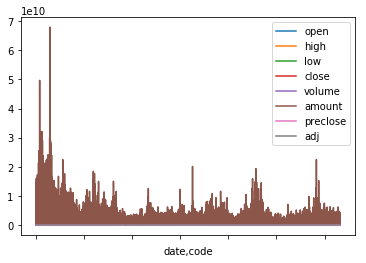

/Volumes/QuantOsUSB/QuantOsUSB/kivy.app/Contents/Resources/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


list index out of range


In [5]:
#训练起始时间
start_date='2015-06-01'
end_date='2017-06-01'
#inst = D.instruments(start_date, end_date, market='CN_STOCK_A')
#print(inst)

#instruments = ['600519']
instruments = QA_code

#hist = D.history_data(instruments, start_date, end_date, fields=['close'])
#全市场前复权计算
hists = QA.QA_fetch_stock_day_adv(instruments, start_date, end_date).to_qfq().data
hist = hists
#print(hist.head())
print(hist.head())

#plt.plot(hist['date'], hist['close'])
hist.plot()
#plt.figure(figsize=(20,20)) #图表长宽量 16，16
#plt.grid(True)
#plt.plot()
plt.show()

# 转化为时间序列数据
hist = hist.ix[:, 'close'].tolist()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 1

# Straightforward way for creating time windows 创建时间窗口的简单方法
X, Y = [], []
for i in range(0, len(hist), STEP): 
    try:
        x_i = hist[i:i+WINDOW]
        y_i = hist[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization 注释它以删除规范化
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

## 神经网络结构
如前所述，我在本文中将只会使用多层感知机算法（MLP）来分析。因为我想展示神经网络是多么容易在金融数据分析中发生过拟合现象，以及如防止它们。想要在卷积神经网络 (RNN) 和递归神经网络 (RNN) 中扩展这些想法是相对容易的，理解这些概念更加重要。和以前一样，我们采用 Keras 架构作为神经网络模型的主要框架。

我建议在每一个仿射层或卷积层后面使用批量归一化 (BatchNormalization) 并且利用  ReLU 作为激活函数。因为这个已经成为了“行业标准”——它们能够有助于更快地训练神经网络。另外一个值得注意的是我们可以在训练中降低学习率。 Keras 上可以利用 **ReduceLROnPlateau()** 函数实现这一要求。

我们利用 L2 范数和 Dropout 来防止过拟合现象。

In [6]:
model = Sequential()
model.add(Dense(64, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
# 加入 Dropout 防止过拟合
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=20, verbose=0, mode='auto')
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Train model 火车模型#历史 模型配合#X队列 Y队列#迭代次数#群子节#啰嗦 #确认_数据#回收 减少#检查点#初期 制止
history = model.fit\
(X_train, Y_train, \
 nb_epoch = 100, \
 batch_size = 128, \
 verbose=1, \
 validation_data=(X_test, Y_test), \
 shuffle=True, \
 callbacks=[reduce_lr, \
            checkpointer, \
            early_stopper]) 

/Volumes/QuantOsUSB/QuantOsUSB/kivy.app/Contents/Resources/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 948324 samples, validate on 316108 samples
Epoch 1/100
948324/948324 [==============================] - 32s 33us/step - loss: 1.6477 - acc: 0.6997 - val_loss: 0.5937 - val_acc: 0.7163

Epoch 00001: val_loss improved from inf to 0.59373, saving model to test.hdf5
Epoch 2/100
948324/948324 [==============================] - 29s 30us/step - loss: 0.5975 - acc: 0.7101 - val_loss: 0.5778 - val_acc: 0.7210

Epoch 00002: val_loss improved from 0.59373 to 0.57783, saving model to test.hdf5
Epoch 3/100
948324/948324 [==============================] - 29s 31us/step - loss: 0.5876 - acc: 0.7119 - val_loss: 0.5727 - val_acc: 0.7202

Epoch 00003: val_loss improved from 0.57783 to 0.57273, saving model to test.hdf5
Epoch 4/100
948324/948324 [==============================] - 30s 31us/step - loss: 0.5861 - acc: 0.7121 - val_loss: 0.5730 - val_acc: 0.7219

Epoch 00004: val_loss did not improve from 0.57273
Epoch 5/100
948324/948324 [==============================] - 30s 32us/step - loss: 0.58

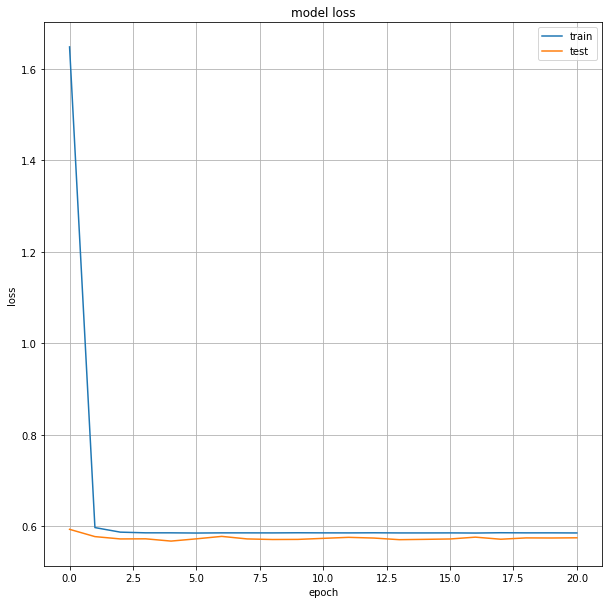

In [12]:
# Visualization of loss 可视化的损失
plt.figure(figsize=(10,10)) #图表长宽量 16，16
plt.grid(True)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') #模型损失 
plt.ylabel('loss') #失利 
plt.xlabel('epoch') #时代
plt.legend(['train', 'test'], loc='best') #培养 测试 最好

plt.show()

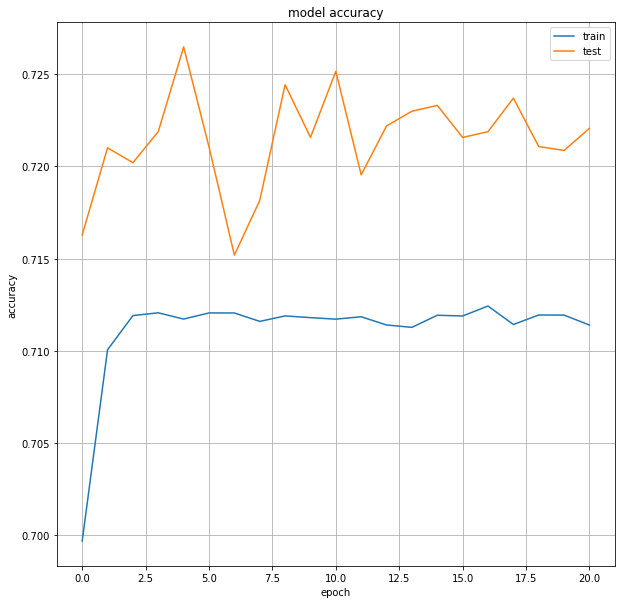

In [13]:
# Visualization of Accuracy 可视化的准确性
plt.figure(figsize=(10,10)) #图表长宽量 16，16
plt.grid(True)
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.title('model accuracy') #模型准确性
plt.ylabel('accuracy') #准确性
plt.xlabel('epoch') #时代
plt.legend(['train', 'test'], loc='best') #培养 测试 最好
plt.show()

## 回测
测试的策略相对比较简单。
若预测为上涨，则满仓，否则空仓。

In [19]:
# 1. 策略基本参数

# 回测起始时间
start_date_2 = '2017-06-01'
# 回测结束时间
end_date_2 = '2019-02-27'
# 策略比较参考标准，以沪深300为例
benchmark = '000300.INDX'
# 证券池 以贵州茅台为例
# instruments = ['000030.SZA']
# 起始资金
capital_base = 100000




In [20]:
# 2. 策略主体函数

# 初始化虚拟账户状态，只在第一个交易日运行
def initialize(context):
    # 设置手续费，买入时万3，卖出是千分之1.3,不足5元以5元计
    context.set_commission(PerOrder(buy_cost=0.0003, sell_cost=0.0013, min_cost=5))

# 策略交易逻辑，每个交易日运行一次
def handle_data(context, data):
    # 在这里添加策略代码
    for instrument in instruments:
        # 字符型股票代码转化成 BigQuant回测引擎所需的股票代码
        instrument = context.symbol(instrument)
        history = data.history(instrument, 'close', 30, '1d').tolist()
        norm_hist = [(np.array(history) - np.mean(history)) / np.std(history)]
        prediction = model.predict(np.asarray(norm_hist))[0]
        
        print(prediction)
        
        if  np.argmax(prediction) == 0 and data.can_trade(instrument):
            order_target_percent(instrument, 1)
        elif np.argmax(prediction) == 1 and data.can_trade(instrument):
            order_target_percent(instrument, 0)



In [21]:
# 3. 启动回测

# 策略回测接口: https://bigquant.com/docs/module_trade.html
m = M.trade.v1(
    instruments=instruments,
    start_date=start_date_2,
    end_date=end_date_2,
    initialize=initialize,
    handle_data=handle_data,
    # 买入订单以开盘价成交
    order_price_field_buy='open',
    # 卖出订单以开盘价成交
    order_price_field_sell='open',
    capital_base=capital_base,
    benchmark=benchmark,
)



NameError: name 'M' is not defined

In [21]:
# 调用风险分析
m.risk_analyze()  

NameError: name 'risk_analyze' is not defined